In [1]:
# %env SM_FRAMEWORK=tf.keras
import zipfile, os, numpy as np, pickle, yaml, gc, tensorflow as tf
import segmentation_models as sm
import tensorflow_addons as tfa
sys.path.append("..")
from model.resnet3d import Resnet3DBuilder
from model.cnn_model import get_model
from keras import backend as K
K.clear_session()
from segmentation_models import Unet
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
class_type = 0 # 0=NL, 1=AP

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
def load_config(config_name):
    with open(config_name) as file:
        config = yaml.safe_load(file)
    return config
config = load_config("utils/model_config.yaml")
datatype='3.0T'
nii_size = config['nii_size']

In [3]:
# path test
top_layer_path_train = config['top_layer_path_train']
top_layer_path = config['top_layer_path']
# S1 [img, msk]
S1_img_stack = config['S1_img_stack']
# S2 label
S2_img_stack = config['S2_img_stack']
# save path
save_path = f'results_log/compose_model/all_NL-test_results_{datatype}'


# S1 model weight path
S1_weights=[config["S1_dense"], config["S1_res"], config["S1_vgg"]]
S1_backbone = ['densenet121', 'resnet50', 'vgg16']
# S2 model weight path
S2_weight=[config["S2_Resnet18"], config["S2_ResNet50"], config["S2_CNN"]]
S2_backbone =['resnet18', 'resnet50', 'cnn']

In [4]:
def S1_dataloader(valid_data='Mix', tune_type='test'):
    if tune_type=='test':
        img_layer_path = top_layer_path[0]
        if valid_data == '3.0T':
            # loading valida data 3.0T + 1.5T: image / masks
            X_valid = np.load(img_layer_path +'/'+ S1_img_stack[0])
            y_valid = np.load(img_layer_path +'/'+ S1_img_stack[1])
    elif tune_type=='train':
        img_layer_path = top_layer_path_train[0]
        X_valid = np.load(img_layer_path +'/'+ S1_img_stack[2])
        y_valid = np.load(img_layer_path +'/'+ S1_img_stack[3])
        
    X_valid = np.reshape(X_valid, (X_valid.shape[0]*32,384,384,1))
    y_valid = np.reshape(y_valid, (y_valid.shape[0]*32,384,384,1))
    return X_valid.astype(np.float32), y_valid.astype(np.int8)

In [5]:
def S1_model_loader(weight_path, backbone, mode):
    S1_X_valid, S1_y_valid= S1_dataloader(valid_data=datatype, tune_type=mode)
    print(f'S1 data shape: img {S1_X_valid.shape} msk {S1_y_valid.shape}')
    model = Unet(backbone, encoder_weights=None, input_shape=(None, None, 1))
    model.load_weights(weight_path)
    Results = model.predict(S1_X_valid, batch_size=1, verbose=1)
    return Results, S1_X_valid, S1_y_valid

In [6]:
def S2_model_loader(S1_pred_X, weight_path, backbone):
    print(S1_pred_X.shape)
    if 'resnet18' in backbone:
        model = Resnet3DBuilder.build_resnet_18((32, nii_size, nii_size, 1), 1)
    elif 'resnet50' in backbone:
        model = Resnet3DBuilder.build_resnet_50((32, nii_size, nii_size, 1), 1)
    elif 'cnn' in backbone:
        model = get_model(depth=32, width=384, height=384, class_num=1, classification_layer='sigmoid')
    
    model.load_weights(weight_path)
    if len(S1_pred_X.shape)==4 and backbone!='cnn':
        S1_pred_X = np.expand_dims(S1_pred_X, axis=-1)
    Results = model.predict(S1_pred_X, batch_size=1, verbose=1)
    return Results

In [7]:
import pandas as pd
if datatype=='3.0T':
    data_n = 0
S2_y_flatten = np.load(top_layer_path[0] + '/' + S2_img_stack[0]).flatten()
S2_model_df = pd.DataFrame(S2_y_flatten, columns=['GT'])
S2_y_flatten_train = np.load(top_layer_path_train[0] + '/' + S2_img_stack[1]).flatten()
S2_model_df_train = pd.DataFrame(S2_y_flatten_train, columns=['GT'])

In [8]:
S1_thresholds = 0.5
S1_pred_stack=[]
S2_pred_stack=[]
S2_pred_stack_train=[]
# ----S1 model test 1 - 3----
mode_list=['train', 'test']
for d in mode_list:
    print(f'Start model = {d}')
    for i in range(3):
        S1_pred, S1_X_valid, S1_y_valid = S1_model_loader(S1_weights[i], S1_backbone[i], d)
        S1_pred = np.reshape(S1_pred, (S1_pred.shape[0]//32,32,384,384))
        S1_y_valid = np.reshape(S1_y_valid, (S1_y_valid.shape[0]//32,32,384,384))
        S1_X_valid = np.reshape(S1_X_valid, (S1_X_valid.shape[0]//32,32,384,384))
        S1_pred = np.where(S1_pred > S1_thresholds, S1_X_valid, S1_X_valid*0)
        S1_pred_stack.append(S1_pred)
        # ----S2 model test 1 - 3----
        for j in range(3):
            print(S1_backbone[i], S2_backbone[j])
            S2_pred = S2_model_loader(S1_pred, S2_weight[j][class_type], S2_backbone[j])
            if d=='test':
                S2_pred_stack.append(S2_pred)
                S2_model_df[f'{S1_backbone[i]} + {S2_backbone[j]}'] = S2_pred.flatten()
            if d=='train':
                S2_pred_stack_train.append(S2_pred)
                S2_model_df_train[f'{S1_backbone[i]} + {S2_backbone[j]}'] = S2_pred.flatten()
        del S1_pred, S2_pred

Start model = train
S1 data shape: img (4480, 384, 384, 1) msk (4480, 384, 384, 1)
4480/4480 [==============================] - 193s 43ms/step
densenet121 resnet18
(140, 32, 384, 384)
140/140 [==============================] - 9s 64ms/step
densenet121 resnet50
(140, 32, 384, 384)
140/140 [==============================] - 13s 96ms/step
densenet121 cnn
(140, 32, 384, 384)
140/140 [==============================] - 7s 51ms/step
S1 data shape: img (4480, 384, 384, 1) msk (4480, 384, 384, 1)
4480/4480 [==============================] - 125s 28ms/step
resnet50 resnet18
(140, 32, 384, 384)
140/140 [==============================] - 9s 63ms/step
resnet50 resnet50
(140, 32, 384, 384)
140/140 [==============================] - 14s 98ms/step
resnet50 cnn
(140, 32, 384, 384)
140/140 [==============================] - 7s 53ms/step
S1 data shape: img (4480, 384, 384, 1) msk (4480, 384, 384, 1)
4480/4480 [==============================] - 87s 19ms/step
vgg16 resnet18
(140, 32, 384, 384)
140/140 [===

In [9]:
# one stage model test
mode_list=['train', 'test']
Only_backbone =['resnet18', 'resnet50']
Only_weight = config["S2_Only"]
for d in mode_list:
    print(f'Start only CNN model = {d}')
    for i in range(2):
        print(Only_backbone[i])
        if d=='test':
            one_stage_X = np.load(os.path.join(top_layer_path[0], S1_img_stack[0]))          
            just_pred = S2_model_loader(one_stage_X, Only_weight[i], Only_backbone[i])
            S2_pred_stack.append(just_pred)
            S2_model_df[f'{Only_backbone[i]}'] = just_pred.flatten()
            del one_stage_X
        elif d=='train':
            one_stage_X = np.load(os.path.join(top_layer_path_train[0], S1_img_stack[2]))
            print(one_stage_X.shape)
            just_pred = S2_model_loader(one_stage_X, Only_weight[i], Only_backbone[i])
            S2_pred_stack_train.append(just_pred)
            S2_model_df_train[f'{Only_backbone[i]}'] = just_pred.flatten()
            del one_stage_X

Start only CNN model = train
resnet18
(140, 32, 384, 384)
(140, 32, 384, 384)
140/140 [==============================] - 9s 65ms/step
resnet50
(140, 32, 384, 384)
(140, 32, 384, 384)
140/140 [==============================] - 15s 107ms/step
Start only CNN model = test
resnet18
(45, 32, 384, 384)
45/45 [==============================] - 3s 77ms/step
resnet50
(45, 32, 384, 384)
45/45 [==============================] - 5s 116ms/step


In [10]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, auc, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
def CI(y_pred, y_true, optimal_th, score_type):
    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        if score_type=='acc':
            score = accuracy_score(y_true[indices], y_pred[indices]>optimal_th)
        elif score_type=='auc':
            score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return confidence_lower, confidence_upper

In [12]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, auc, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix
def Find_Optimal_Cutoff(FPR, TPR, threshold):
    y = TPR - FPR
    
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point


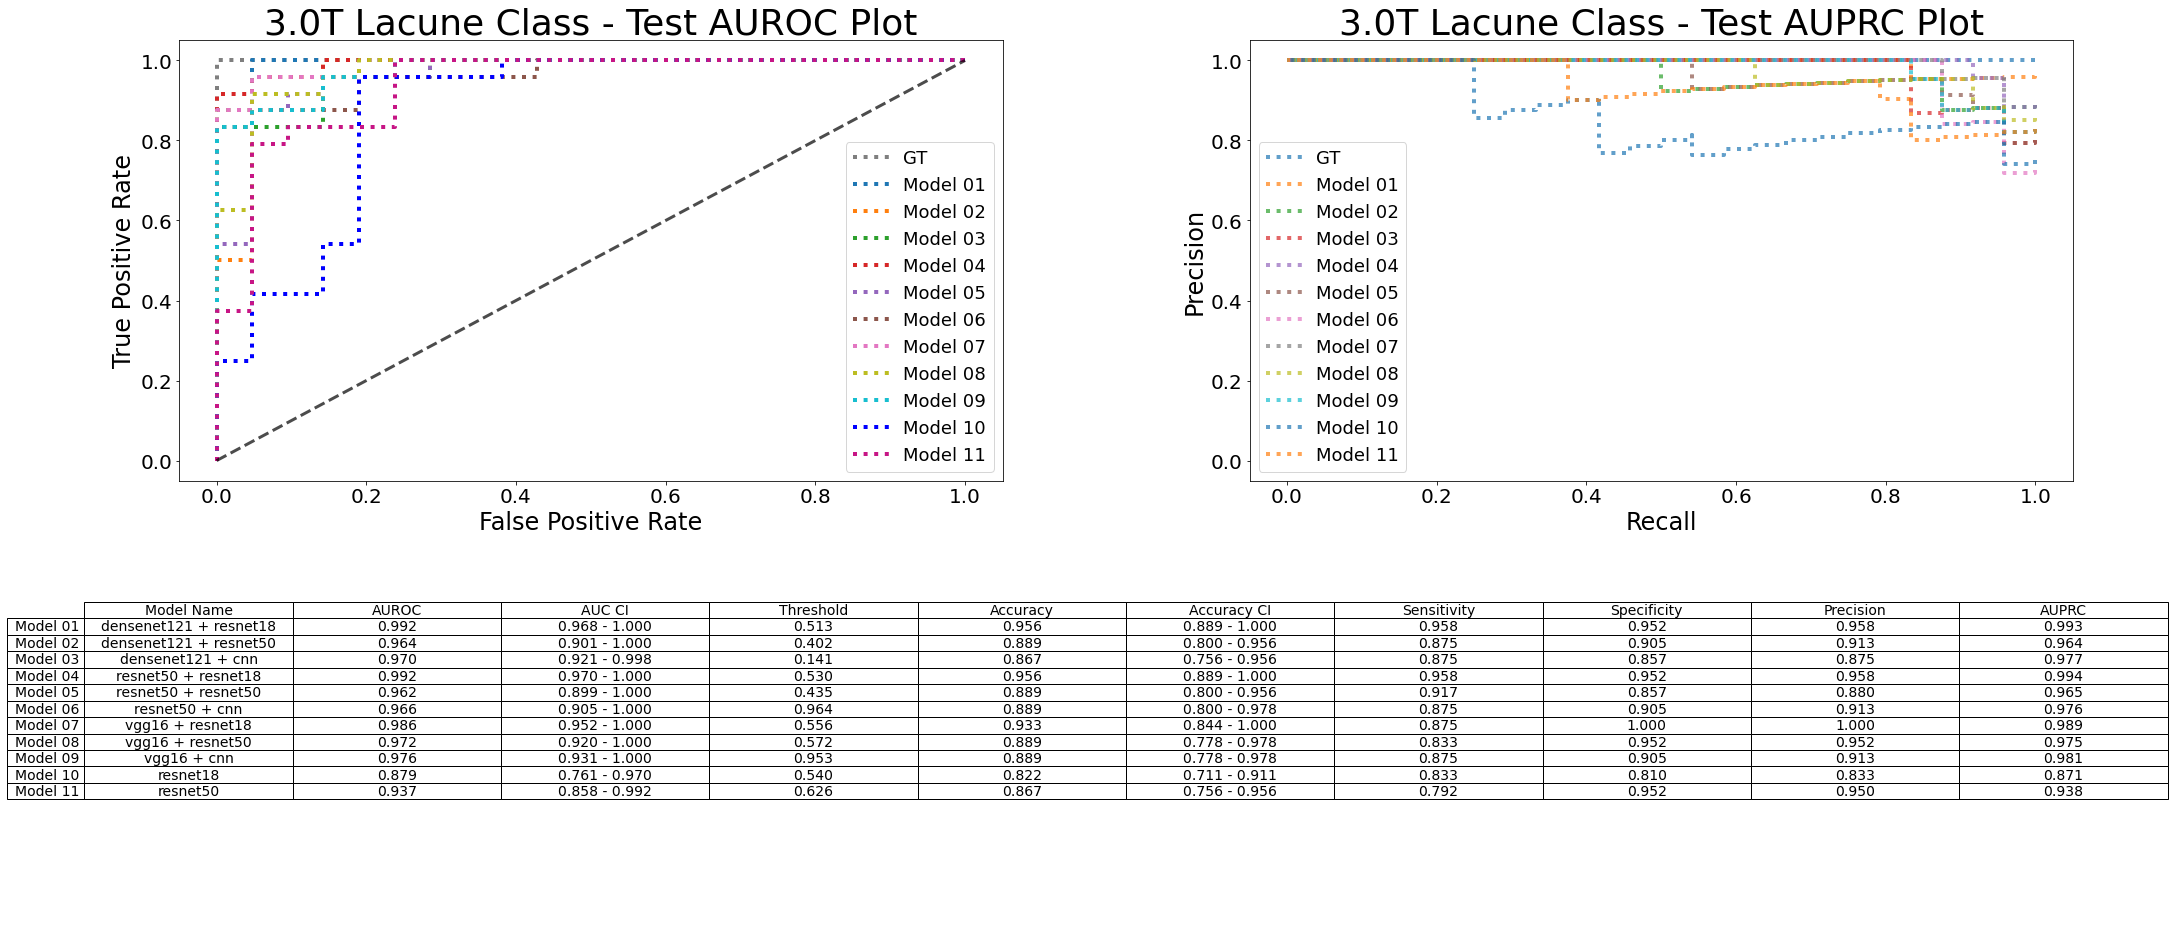

<Figure size 432x288 with 0 Axes>

In [13]:
fig = plt.figure(figsize=(30, 13))
parameters = {
    'xtick.labelsize': 20,
    'ytick.labelsize': 20}
plt.rcParams.update(parameters)
grid = plt.GridSpec(nrows=2, ncols=2, figure=fig)
ax2 = plt.subplot(grid[0, 0])
ax3 = plt.subplot(grid[0, 1])
ax4 = plt.subplot(grid[1, 0:2])

y_flatten = S2_model_df['GT']
y_flatten_train = S2_model_df_train['GT']
count=0
result_table1 = []
model_num = []
next_ = 0
optimal_th = 0.5

color = ['tab:gray','tab:blue','tab:orange','tab:green','tab:red','tab:purple',
         'tab:brown','tab:pink','tab:olive','tab:cyan','b','mediumvioletred']
d_style = ['X','+','H','*','s','4','^','v','o','D','p','d']

for i in S2_model_df:
    p_flatten = S2_model_df[i]
    p_flatten_train = S2_model_df_train[i]
# -------------------------------plot AUROC and Cut-off Point-------------------
    auc = roc_auc_score(y_flatten, p_flatten)
    fpr, tpr, ths = roc_curve(y_flatten, p_flatten)
    fpr2, tpr2, ths2 = roc_curve(y_flatten_train, p_flatten_train)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr2, FPR=fpr2, threshold=ths2)
# -------------------------------plot AUPRC-----------------------------
    ap = average_precision_score(y_flatten, p_flatten)
    pre, rec, _ = precision_recall_curve(y_flatten, p_flatten)

    # ----table----
    if i=='GT':
        ax2.plot(fpr, tpr, lw=4, linestyle='dotted', color=color[count], label = f'GT')
        ax3.step(rec, pre, lw=4, linestyle='dotted', label = f'GT', alpha=0.7)
    elif i !='GT':
        if next_+1<10:
            model_ns = f'Model 0{next_+1}'
            model_num.append(model_ns)
        else:
            model_ns = f'Model {next_+1}'
            model_num.append(model_ns)
        ax2.plot(fpr, tpr, lw=4, linestyle='dotted', color=color[count], label = f'{model_ns}', )
        ax3.step(rec, pre, lw=4, linestyle='dotted', label = f'{model_ns}', alpha=0.7)
        result_table1.append([i])
        p_flatten = S2_model_df[i]
        cl1,cu1 =CI(p_flatten, y_flatten, optimal_th, score_type='auc')

        cl2,cu2 =CI(p_flatten, y_flatten, optimal_th, score_type='acc')
        y_proba_th = ((p_flatten > optimal_th).astype(np.int8))
        acc = accuracy_score(y_flatten, y_proba_th)
        CM = confusion_matrix(y_flatten, y_proba_th)
        result_table1[next_].append(f'{auc:.3f}')
        result_table1[next_].append(f'{cl1:.3f} - {cu1:.3f}')
        result_table1[next_].append(f'{optimal_th:.3f}')
        result_table1[next_].append(f'{acc:.3f}')
        result_table1[next_].append(f'{cl2:.3f} - {cu2:.3f}')
        result_table1[next_].append(f'{(CM[1,1]/(CM[1,1]+CM[1,0])):.3f}')
        result_table1[next_].append(f'{(CM[0,0]/(CM[0,0]+CM[0,1])):.3f}')
        result_table1[next_].append(f'{(CM[1,1]/(CM[1,1]+CM[0,1])):.3f}')
        result_table1[next_].append(f'{ap:.3f}')
    # ----table----
        next_+=1
    count+=1

ax2.plot([0, 1], [0, 1], linestyle='--', lw=3, color='black', alpha=.7)
ax2.legend(fontsize=18, loc='lower right')
if class_type == 0:
    ax2.set_title(f'{datatype} Lacune Class - Test AUROC Plot', fontsize=36)
elif class_type==1:
    ax2.set_title(f'{datatype} Circulation A/P Class - Test AUROC Plot', fontsize=36)
ax2.set_xlabel('False Positive Rate', fontsize=24)
ax2.set_ylabel('True Positive Rate', fontsize=24)
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])

ax3.legend(fontsize=18, loc='lower left')
if class_type == 0:
    ax3.set_title(f'{datatype} Lacune Class - Test AUPRC Plot', fontsize=36)
elif class_type==1:
    ax3.set_title(f'{datatype}  Circulation A/P Class - Test AUPRC Plot', fontsize=36)
ax3.set_xlabel('Recall', fontsize=24)
ax3.set_ylabel('Precision', fontsize=24)

ax3.set_xlim([-0.05, 1.05])
ax3.set_ylim([-0.05, 1.05])

result_table1 = pd.DataFrame(result_table1, columns = ['Model Name', 'AUROC', 'AUC CI',
                                                        'Threshold', 'Accuracy', 'Accuracy CI',
                                                       'Sensitivity', 'Specificity', 'Precision','AUPRC'])

ax4.axis('off')
ax4.axis('tight')
tab1 = ax4.table(cellText=result_table1.values, rowLabels = model_num, colLabels=result_table1.columns, cellLoc='center',loc='center')
tab1.scale(1.1,1)
tab1.auto_set_font_size(False)
tab1.set_fontsize(14)

if not os.path.exists(save_path):
    os.makedirs(save_path)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0)
save_plt = './plot_results/'
if not os.path.exists(save_plt):
    os.makedirs(save_plt)
if class_type ==0:
    plt.savefig(save_plt + f'{datatype} Lacune ALL model - Curve Plot - youden .png', dpi=600)
elif class_type==1:
    print(save_plt + f'{datatype} Circulation AP ALL model - Curve Plot - youden.png')
    plt.savefig(save_plt + f'{datatype} Circulation AP ALL model - Curve Plot - youden.png', dpi=600)
# plt.savefig(f'{save_path}/{datatype} Lacune ALL model - Curve Plot .jpg')
plt.show()
plt.clf()

In [14]:
result_table1.to_csv(f"{config['class_name']} {datatype} all model_preformance - youden.csv",index=0)
result_table1

,Model Name,AUROC,AUC CI,Threshold,Accuracy,Accuracy CI,Sensitivity,Specificity,Precision,AUPRC
0,densenet121 + resnet18,0.992,0.968 - 1.000,0.513,0.956,0.889 - 1.000,0.958,0.952,0.958,0.993
1,densenet121 + resnet50,0.964,0.901 - 1.000,0.402,0.889,0.800 - 0.956,0.875,0.905,0.913,0.964
2,densenet121 + cnn,0.970,0.921 - 0.998,0.141,0.867,0.756 - 0.956,0.875,0.857,0.875,0.977
3,resnet50 + resnet18,0.992,0.970 - 1.000,0.530,0.956,0.889 - 1.000,0.958,0.952,0.958,0.994
4,resnet50 + resnet50,0.962,0.899 - 1.000,0.435,0.889,0.800 - 0.956,0.917,0.857,0.880,0.965
5,resnet50 + cnn,0.966,0.905 - 1.000,0.964,0.889,0.800 - 0.978,0.875,0.905,0.913,0.976
6,vgg16 + resnet18,0.986,0.952 - 1.000,0.556,0.933,0.844 - 1.000,0.875,1.000,1.000,0.989
7,vgg16 + resnet50,0.972,0.920 - 1.000,0.572,0.889,0.778 - 0.978,0.833,0.952,0.952,0.975
8,vgg16 + cnn,0.976,0.931 - 1.000,0.953,0.889,0.778 - 0.978,0.875,0.905,0.913,0.981
9,resnet18,0.879,0.761 - 0.970,0.540,0.822,0.711 - 0.911,0.833,0.810,0.833,0.871
